# import packages

In [1]:
##%reload_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing


# load data

In [2]:
cytokine_data = pd.read_csv('../data/combine_031517.csv')
cytokine_data = cytokine_data.drop(['CHEX1', 'CHEX2', 'CHEX3', 'CHEX4'], axis = 1)
cytokines = cytokine_data.iloc[:,cytokine_data.columns.get_loc('CD40L'):]
cytokines

train_set, test_set = train_test_split(cytokines, test_size=0.2)
train_set, val_set = train_test_split(cytokines, test_size=0.2)

# preprocess data

In [3]:
## preprocess functions
def make_standardize(x):
    n,p = x.shape
    X = np.copy(x)
    mus = []
    stds = []
    for i in range(p):
        x = X[:,i]
        mu = np.mean(x)
        st = np.std(x)
        x = x - mu
        x = x / st
        X[:,i] = x
        mus.append(mu)
        stds.append(st)
    return X,mus,stds

def remove_cyto_outliers(lD_cyto):
        X = lD_cyto
        Xs,mus,stds = make_standardize(X)
        upper = np.asarray(mus)+np.asarray(stds)*3
        lower = np.asarray(mus)-np.asarray(stds)*3
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[i,j]>upper[j]: X[i,j] = upper[j]
                if X[i,j]<lower[j]: X[i,j] = lower[j]
        return X


In [4]:
## standardize and remove outliers
cytokines_np = cytokines.values
cytokines_np = remove_cyto_outliers(cytokines_np)
cytokines_np = make_standardize(cytokines_np)
cytokines_np[0]

##extract age
#cytokine_data.AGE

array([[-0.59585464, -0.79589227,  0.28511765, ..., -0.77488853,
        -0.47718653, -0.23196626],
       [-0.38711635, -0.22572978, -0.39566277, ..., -0.72295204,
        -0.22700936, -0.10777838],
       [-0.46438067,  2.71974709,  0.8779951 , ..., -0.68281931,
        -0.14090448,  0.513161  ],
       ...,
       [-0.27371227, -0.37806327,  0.41229641, ..., -0.54589585,
         2.57905384,  0.03373803],
       [ 1.09399084,  0.40318992, -1.43553616, ..., -0.56124072,
         2.81565156,  1.19186218],
       [-0.25065759, -0.30516081, -1.58889878, ..., -0.33224804,
         2.60117766,  2.82652121]])

# create model

In [5]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim):
    super(Encoder, self).__init__()
#     self.hidden_layer = tf.keras.layers.Dense(
#       units=intermediate_dim,
#       activation=tf.nn.relu,
#       kernel_initializer='he_uniform'
#     )
#     self.output_layer = tf.keras.layers.Dense(
#       units=intermediate_dim,
#       activation=tf.nn.sigmoid
#     )
#     
#   def call(self, input_features):
#     activation = self.hidden_layer(input_features)
#     return self.output_layer(activation)

    self.hidden_layer = tf.keras.Sequential([
#       tf.keras.layers.Dense(50, activation=tf.nn.relu, input_shape=(50,)),  # input shape required
#       tf.keras.layers.Dense(50, activation='tanh'),
      tf.keras.layers.Dense(5, activation='tanh'),
#       tf.keras.layers.Dense(1)
      tf.keras.layers.Dense(5, activation='tanh')
    ])
    
  def call(self, input_features):
    return self.hidden_layer(input_features)

In [6]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Decoder, self).__init__()
#     self.hidden_layer = tf.keras.layers.Dense(
#       units=intermediate_dim,
#       activation=tf.nn.relu,
#       kernel_initializer='he_uniform'
#     )
#     self.output_layer = tf.keras.layers.Dense(
#       units=original_dim,
#       activation=tf.nn.sigmoid
#     )
  
#   def call(self, code):
#     activation = self.hidden_layer(code)
#     return self.output_layer(activation)

    self.hidden_layer = tf.keras.Sequential([
      layers.Dense(5, activation="tanh"),
#       layers.Dense(50, activation="tanh"),
      layers.Dense(50, activation="sigmoid")])
    
  def call(self, code):
    return self.hidden_layer(code)
    
    

In [7]:
class Age_layer(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Age_layer, self).__init__()

    self.hidden_layer = tf.keras.Sequential([
      layers.Dense(1, activation="linear")])
    
  def call(self, code):
    return self.hidden_layer(code)
    
    

In [8]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)
    self.age_layer = Age_layer(intermediate_dim=intermediate_dim, original_dim=original_dim)
  
  def call(self, input_features):
#     import pdb; pdb.set_trace()
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    pred_age = self.age_layer(code)
    return (reconstructed, pred_age)

#   def call(self, input_features):
#     code = self.encoder(input_features)
#     pred_age = self.age_layer(code)
#     return pred_age


#   def calc_age(self, input_features):
#     #import pdb; pdb.set_trace()
#     code = self.encoder(input_features)
#     reg = LinearRegression().fit(X, y)
#     reg.score(X, y)
#     return code

In [9]:
def loss(model, original):
  #reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  #return reconstruction_error

  lam = 0.2
  reconstruction, pred_age = model(original[0])
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(reconstruction, original[0])))
  age_error = tf.reduce_mean(tf.square(original[1] - pred_age))
#   import pdb; pdb.set_trace()
  
  ## regularization
  l2_norms = [tf.nn.l2_loss(v) for v in model.trainable_variables]
  l2_norm = tf.reduce_sum(l2_norms)
#   cost = (1-lam)*reconstruction_error + lam*age_error + 0.001*l2_norm
  cost = (1-lam)*reconstruction_error + lam*age_error 
  return cost

#   import pdb; pdb.set_trace()
#   lam = 0.2
#   pred_age = model(original[0])
# #   reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(reconstruction, original[0])))
#   age_error = tf.reduce_mean(tf.square(original[1] - pred_age))
#   cost = age_error
#   return cost


#   return reconstruction_error

In [10]:
def train(loss, model, opt, original):
  #import pdb; pdb.set_trace()
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

# train model

In [11]:
len(cytokines_np)

3

In [12]:
## parameter
learning_rate = 0.01
batch_size = 32
epochs = 200

# learning_rate = 0.002
# batch_size = 10 
# epochs = 1000

In [13]:
autoencoder = Autoencoder(intermediate_dim=3, original_dim=50)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

# (training_features, _), (test_features, _) = tf.keras.datasets.mnist.load_data()
# training_features = training_features / np.max(training_features)
# training_features = training_features.reshape(training_features.shape[0],
#                                               training_features.shape[1] * training_features.shape[2])
# training_features = training_features.astype('float32')
# training_features = train_set.to_numpy().astype('float32')
training_features = cytokines_np[0].astype('float32')
cyto_age = cytokine_data.AGE.astype('float32')

cyto_age = (cyto_age - np.mean(cyto_age))/np.std(cyto_age)
# # cyto_age * np.std(cytokine_data.AGE) + np.mean(cytokine_data.AGE)

training_dataset = tf.data.Dataset.from_tensor_slices((training_features,cyto_age))
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in range(epochs):
      print(epoch)
      for step, batch_features in enumerate(training_dataset):
#         import pdb; pdb.set_trace()
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
      print(loss_values)
#         original = tf.reshape(batch_features, (batch_features.shape[0], 28, 28, 1))
#         reconstructed = tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 28, 28, 1))
#         tf.summary.scalar('loss', loss_values, step=step)
#         tf.summary.image('original', original, max_outputs=10, step=step)
#         tf.summary.image('reconstructed', reconstructed, max_outputs=10, step=step)

0
tf.Tensor(0.70929307, shape=(), dtype=float32)
1
tf.Tensor(1.1755341, shape=(), dtype=float32)
2
tf.Tensor(0.7134578, shape=(), dtype=float32)
3
tf.Tensor(1.7915986, shape=(), dtype=float32)
4
tf.Tensor(0.5517706, shape=(), dtype=float32)
5
tf.Tensor(1.1073053, shape=(), dtype=float32)
6
tf.Tensor(1.0487788, shape=(), dtype=float32)
7
tf.Tensor(0.6422026, shape=(), dtype=float32)
8
tf.Tensor(1.0107394, shape=(), dtype=float32)
9
tf.Tensor(0.5904094, shape=(), dtype=float32)
10
tf.Tensor(0.9686862, shape=(), dtype=float32)
11
tf.Tensor(0.5607465, shape=(), dtype=float32)
12
tf.Tensor(1.9034504, shape=(), dtype=float32)
13
tf.Tensor(0.55063045, shape=(), dtype=float32)
14
tf.Tensor(0.53790057, shape=(), dtype=float32)
15
tf.Tensor(0.51643974, shape=(), dtype=float32)
16
tf.Tensor(0.77416414, shape=(), dtype=float32)
17
tf.Tensor(0.52268237, shape=(), dtype=float32)
18
tf.Tensor(0.5158314, shape=(), dtype=float32)
19
tf.Tensor(0.48723218, shape=(), dtype=float32)
20
tf.Tensor(1.1429037,

In [14]:
tf.math.reduce_mean(abs((autoencoder(training_features)[1] * np.std(cytokine_data.AGE) + np.mean(cytokine_data.AGE)) - cytokine_data.AGE))
mean_squared_error((autoencoder(training_features)[1] * np.std(cytokine_data.AGE) + np.mean(cytokine_data.AGE)) , cytokine_data.AGE)

345.6553469633893

In [15]:
print(autoencoder(training_features)[1] - cyto_age)
print(tf.math.reduce_mean(abs(autoencoder(training_features)[1] - cyto_age)))
print(tf.math.reduce_mean((autoencoder(training_features)[1] - cyto_age)**2))
print(mean_squared_error(autoencoder(training_features)[1] , cyto_age))

tf.Tensor(
[[ 0.06234313 -0.20996466 -0.7904165  ...  0.86934876 -0.1257301
   0.7994524 ]
 [ 0.0477461  -0.22456169 -0.80501354 ...  0.85475177 -0.14032713
   0.7848554 ]
 [ 0.12257809 -0.1497297  -0.7301816  ...  0.9295838  -0.06549513
   0.85968745]
 ...
 [-0.44201565 -0.7143234  -1.2947752  ...  0.36499003 -0.63008887
   0.2950937 ]
 [-0.29340842 -0.5657162  -1.146168   ...  0.51359725 -0.48148164
   0.4437009 ]
 [-0.40167135 -0.67397916 -1.254431   ...  0.40533432 -0.58974457
   0.33543798]], shape=(1001, 1001), dtype=float32)
tf.Tensor(0.89550835, shape=(), dtype=float32)
tf.Tensor(1.1187584, shape=(), dtype=float32)
0.7709554


## Jacobian

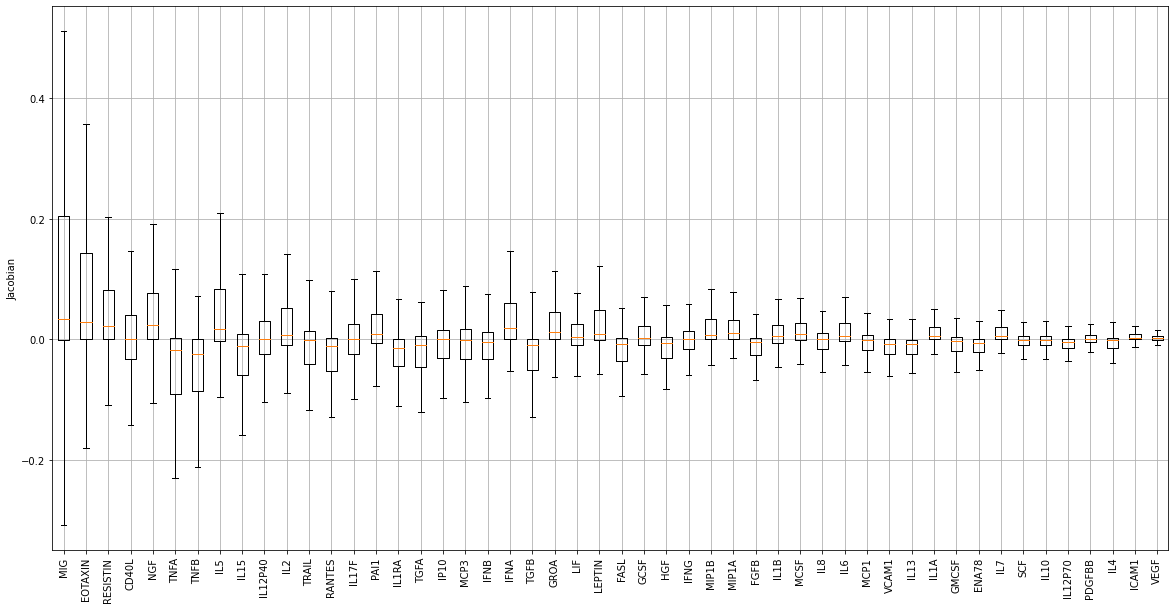

In [16]:
# training_features.shape
def get_Jacobian(training_set,eps=1e-3):
    n,p = training_set.shape
    J = np.zeros([n,p])
    for i in range(p):
        #print(i)
        x0 = training_set.copy()
        x1 = training_set.copy()
#         import pdb; pdb.set_trace()
        x0[:,i] = x0[:,i] - eps
        x1[:,i] = x1[:,i] + eps
        J[:,i:i+1] = ((autoencoder(x1)[1] \
                      - autoencoder(x0)[1])/(2.0*eps))[:,0:0+1]
    return J

J = get_Jacobian(training_features)
training_features
J.shape

J.shape
#plotting jacobian
xlb = cytokines.columns
# lst = np.argsort(-np.sum(np.abs(J),axis=0))
# lst = np.argsort(-np.mean(np.abs(J),axis=0))
lst = np.argsort(-np.median(np.abs(J),axis=0))
# lst = np.argsort(-np.sum((J),axis=0))
plt.figure(figsize=[20,10])
plt.boxplot(J[:,lst], showfliers=False)
plt.grid()
plt.xticks(np.arange(len(xlb))+1,xlb[lst],rotation='vertical')
plt.ylabel('Jacobian')
plt.show()

In [17]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  285       
_________________________________________________________________
decoder (Decoder)            multiple                  330       
_________________________________________________________________
age_layer (Age_layer)        multiple                  6         
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


# Integrated Gradients

In [18]:
model = autoencoder 

baseline = tf.zeros(shape=(1001,50))

m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

training_features.shape

def interpolate_images(baseline,image,alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
#   alphas_x = alphas
#   baseline_x = baseline
#   input_x = image
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

interpolated_images = interpolate_images(
    baseline=baseline,
    image=training_features,
    alphas=alphas)

interpolated_images.shape

def compute_gradients(images):
  with tf.GradientTape() as tape:
    tape.watch(images)
#     logits = model(images)
#     probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    #import pdb; pdb.set_trace()
    agels = [i[1] for i in map(model, images)]
#     res = [tf.reduce_mean(tf.square(cyto_age - model_out[1])) for age_mtx in agels]
    res = [tf.reduce_mean(tf.square(tf.subtract(cyto_age, tf.reshape(age_mtx, [-1])))) for age_mtx in agels]
    res = tf.convert_to_tensor(res)
  return tape.gradient(res, images)


path_gradients = compute_gradients(images=interpolated_images)
path_gradients.shape
    

TensorShape([51, 1001, 50])

In [19]:
batch_size
alphas[3:5]

for alpha in tf.range(0, len(alphas), batch_size):
    print(alpha)
    from_ = alpha
    print('frommmm', from_)
    to = tf.minimum(from_ + batch_size, len(alphas))
    print('toooo', to)
    alpha_batch = alphas[from_:to]
    print(alpha_batch.shape)
    print(alpha_batch)

tf.Tensor(0, shape=(), dtype=int32)
frommmm tf.Tensor(0, shape=(), dtype=int32)
toooo tf.Tensor(32, shape=(), dtype=int32)
(32,)
tf.Tensor(
[0.         0.02       0.04       0.06       0.08       0.09999999
 0.12       0.14       0.16       0.17999999 0.19999999 0.22
 0.24       0.26       0.28       0.29999998 0.32       0.34
 0.35999998 0.38       0.39999998 0.42       0.44       0.45999998
 0.48       0.5        0.52       0.53999996 0.56       0.58
 0.59999996 0.62      ], shape=(32,), dtype=float32)
tf.Tensor(32, shape=(), dtype=int32)
frommmm tf.Tensor(32, shape=(), dtype=int32)
toooo tf.Tensor(51, shape=(), dtype=int32)
(19,)
tf.Tensor(
[0.64       0.65999997 0.68       0.7        0.71999997 0.74
 0.76       0.78       0.79999995 0.82       0.84       0.85999995
 0.88       0.9        0.91999996 0.94       0.96       0.97999996
 1.        ], shape=(19,), dtype=float32)


In [20]:
gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
gradient_batches

for alpha in tf.range(0, len(alphas), batch_size):
#     print(alpha)
    from_ = alpha
#     print('frommmm', from_)
    to = tf.minimum(from_ + batch_size, len(alphas))
#     print('toooo', to)
    alpha_batch = alphas[from_:to]
#     print(alpha_batch.shape)
#     print(alpha_batch)
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=training_features,
                                                           alphas=alpha_batch)
    
    gradient_batch = compute_gradients(images=interpolated_path_input_batch)
    
        # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
#     gradient_batches.read(0)
    

In [21]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [22]:
total_gradients = gradient_batches.stack()
total_gradients

avg_gradients = integral_approximation(gradients=total_gradients)

# 5. Scale integrated gradients with respect to input.
integrated_gradients = (training_features - baseline) * avg_gradients
integrated_gradients


<tf.Tensor: shape=(1001, 50), dtype=float32, numpy=
array([[ 1.2429418e-05, -1.1256054e-06, -4.1919916e-06, ...,
        -1.0908787e-05,  4.8306133e-06, -3.9432192e-07],
       [-1.1723601e-05,  3.6461168e-07, -1.1654918e-05, ...,
         1.8100907e-05, -2.6640967e-06,  6.6788675e-07],
       [-6.0756174e-05, -2.0511688e-05,  7.6611279e-05, ...,
         5.6547800e-05, -8.7783237e-06, -6.2517106e-06],
       ...,
       [-8.0955375e-05,  4.5828889e-05,  3.0798966e-04, ...,
         1.7351810e-04, -2.1467441e-04,  1.4653165e-06],
       [-9.3499999e-05,  7.1586060e-06,  1.8659874e-04, ...,
        -4.0221821e-05, -2.2190590e-05, -2.0434279e-06],
       [-9.5250238e-05,  4.4986129e-05, -1.5065974e-03, ...,
         1.3925604e-04, -2.5735458e-04,  1.1534129e-04]], dtype=float32)>

In [23]:


#@tf.function
def integrated_gradients(baseline,
                         image,
                         m_steps=50,
#                          batch_size=32):
                         batch_size=10):
    
#   import pdb; pdb.set_trace()
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [24]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=training_features,
                                       m_steps=240)



ig_attributions.shape

TensorShape([1001, 50])

In [25]:
ig_attributions.shape

TensorShape([1001, 50])

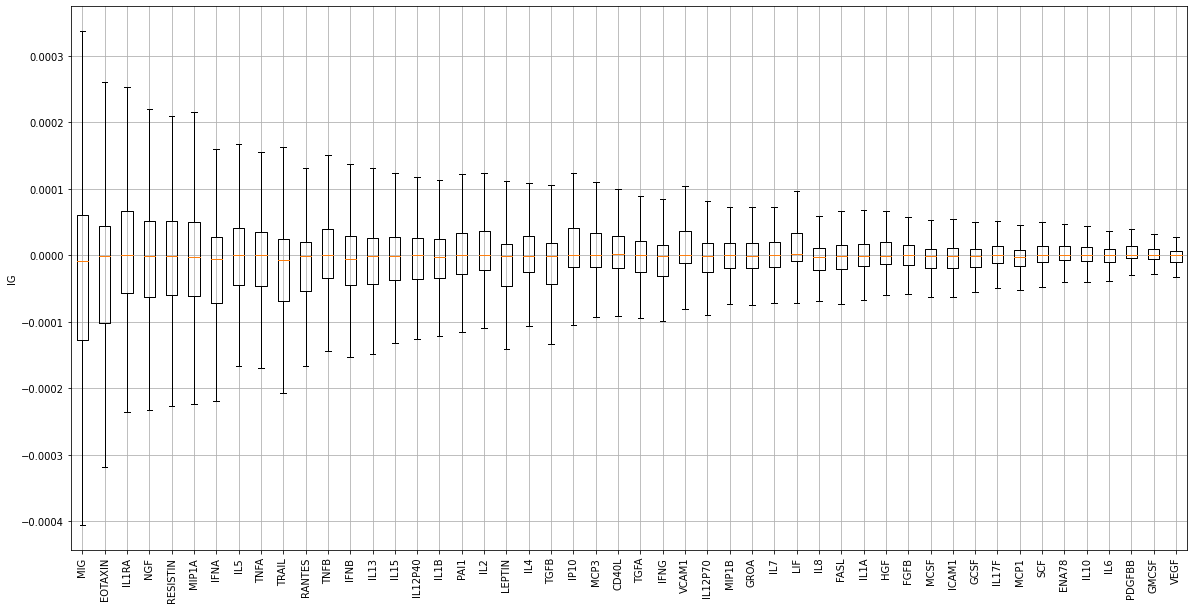

In [26]:
### plotting IG box plot
J.shape
ig_attributions.numpy().shape
xlb = cytokines.columns
lst = np.argsort(-np.median(np.abs(ig_attributions.numpy()),axis=0))
plt.figure(figsize=[20,10])
plt.boxplot(ig_attributions.numpy()[:,lst], showfliers=False)
plt.grid()
plt.xticks(np.arange(len(xlb))+1,xlb[lst],rotation='vertical')
plt.ylabel('IG')
plt.show()


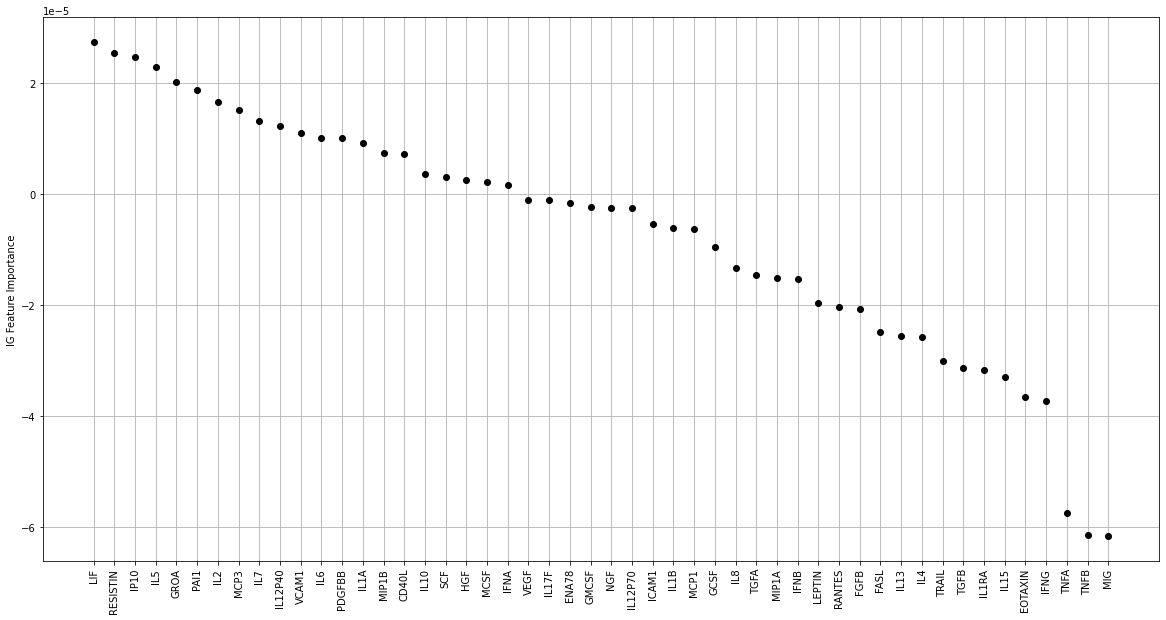

In [30]:
## IG mean
ig_attributions.numpy().sum(axis = 0).shape
ig_attributions.numpy().sum(axis = 0)
all_features_imp = pd.DataFrame(list(zip(cytokines.columns,
#                 (ig_attributions).numpy().sum(axis = 0))),
#                 abs(ig_attributions).numpy().sum(axis = 0))),
#                 abs(ig_attributions).numpy().mean(axis = 0))),
                (ig_attributions).numpy().mean(axis = 0))),
#                 (ig_attributions).numpy().median(axis = 0))),
#                 np.median((ig_attributions).numpy(), axis = 0))),
#              perm.feature_importances_std_*2)),
#              columns = ['Names', 'Mean', 'Std'])
             columns = ['Names', 'Sum'])
all_features_imp
all_features_imp = all_features_imp.sort_values(by = ['Sum'], ascending=False)
plt.figure(figsize=[20,10])
plt.errorbar(all_features_imp.Names,
             all_features_imp.Sum,
             fmt='ok', lw=3)
plt.grid()
plt.xticks(np.arange(len(all_features_imp.Names)),
           all_features_imp.Names,rotation='vertical')
plt.ylabel('IG Feature Importance')
plt.show()

## different version

#input = layers.Input(shape=(28, 28, 1))
input = layers.Input(shape=(50))

# Encoder
x = layers.Dense(3, activation="relu")(input)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Dense(3, activation="relu")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Dense(3, activation="relu")(x)
x = layers.Dense(3, activation="relu")(x)
x = layers.Dense(5, activation="sigmoid")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss=loss)
autoencoder.summary()

autoencoder.fit(
    x=train_set.values,
    y=train_set.values,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(train_set.values, train_set.values),
)


train_set.shape

# another version 2

latent_dim = 3 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
#       layers.Flatten(),
      layers.Dense(3, activation=tf.nn.relu, input_shape=(50,)),
      layers.Dense(3, activation=tf.nn.relu),
      layers.Dense(3, activation=tf.nn.relu),
    ])
    self.decoder = tf.keras.Sequential([
#       layers.Dense(3, activation='sigmoid'),
#       layers.Reshape((1, 50))
      layers.Dense(3, activation=tf.nn.relu),
      layers.Dense(50, activation=tf.nn.relu),
      layers.Dense(50, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

#autoencoder.compile(optimizer='adam', loss=loss)
def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())



autoencoder.fit(cytokines_np[0], cytokines_np[0],
                epochs=2000,
                shuffle=True,
                batch_size = 30,
                validation_data=(cytokines_np[0], cytokines_np[0]))

autoencoder.summary()

autoencoder(cytokines_np[0])